In [1]:
from pyrosm import OSM, get_data

import osmnx as ox
import graph_tool as gt
import networkx as nx
import igraph as ig
import geopandas as gpd
import pandas as pd
import numpy as np

In [3]:
%%time 
osm = OSM(get_data("New York City"))

Downloaded Protobuf data 'newyorkcity.osm.pbf' (83.75 MB) to:
'/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/pyrosm/newyorkcity.osm.pbf'
CPU times: user 489 ms, sys: 477 ms, total: 967 ms
Wall time: 20.7 s


In [2]:
osm = OSM("/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/pyrosm/newyorkcity.osm.pbf")

In [3]:
%%time
roads = osm.get_network(network_type="driving")
paths = osm.get_network(network_type="walking")

CPU times: user 1min 18s, sys: 3.48 s, total: 1min 21s
Wall time: 1min 21s


In [4]:
roads = roads.to_crs('epsg:2263')
paths = paths.to_crs('epsg:2263')

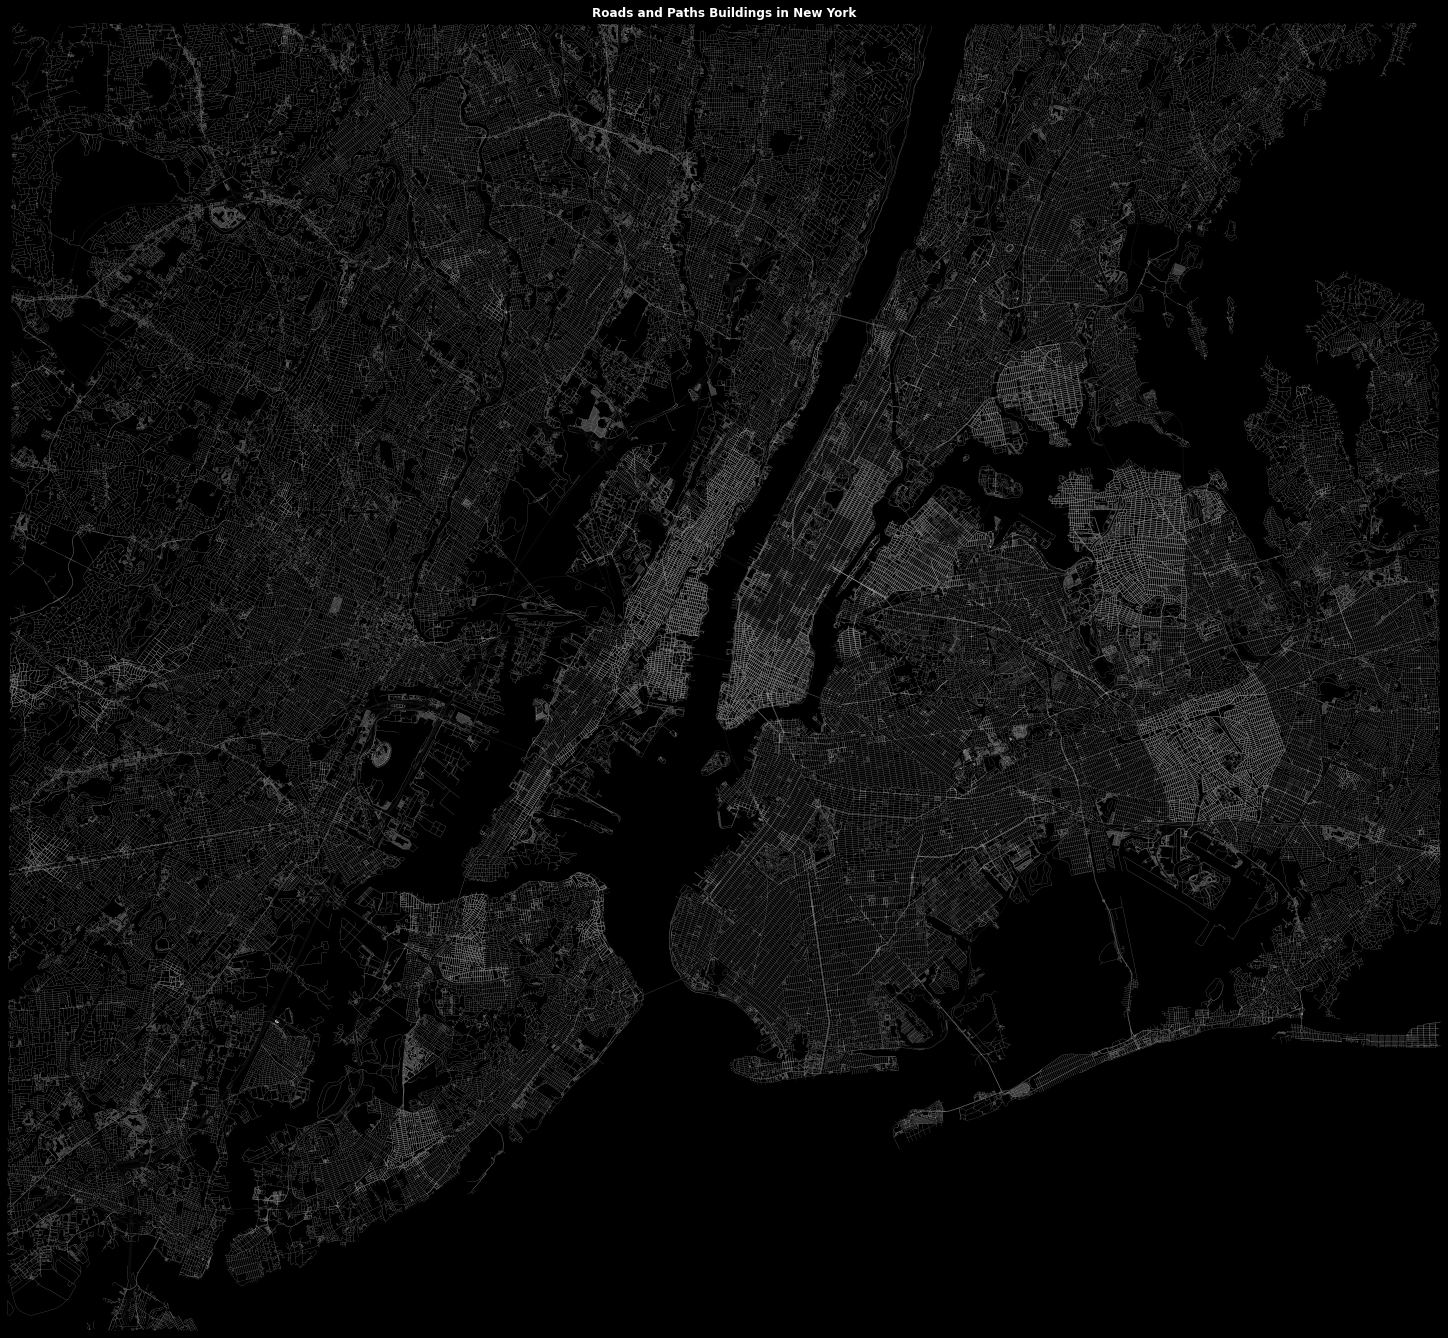

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

roads.plot(ax=ax, color='w', alpha=0.5, lw=0.05)
paths.plot(ax=ax, color='w', alpha=1.0, lw=0.10)
    
ax.set_title("Roads and Paths in New York", color='w', weight='bold')

ax.margins(0)
ax.axis('off')
    
fig.savefig('urban-morphology-nyc-roads.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [6]:
%%time
nodes, edges = osm.get_network(nodes=True, network_type="driving")

CPU times: user 21.1 s, sys: 840 ms, total: 21.9 s
Wall time: 22 s


In [7]:
%%time
G = osm.to_graph(nodes, edges, graph_type="networkx")

CPU times: user 1min 25s, sys: 3.66 s, total: 1min 29s
Wall time: 3min 53s


In [8]:
print(len(G.nodes))
print(len(G.edges))

1014578
1934313


In [9]:
%%time
att_list = ['geometry']
for n1, n2, d in G.edges(data=True):
    for att in att_list:
        d.pop(att, None)

G = ox.simplification.simplify_graph(G)

print(len(G.nodes))
print(len(G.edges))

299258
732003
CPU times: user 1min 39s, sys: 2.42 s, total: 1min 41s
Wall time: 1min 41s


In [16]:
%%time
ox.io.save_graphml(G, filepath="nyc.graphml")

CPU times: user 3min 54s, sys: 8.32 s, total: 4min 3s
Wall time: 4min 4s


In [10]:
%%time
G_gt = gt.load_graph("nyc.graphml")

CPU times: user 46.3 s, sys: 1.13 s, total: 47.4 s
Wall time: 47.2 s


In [11]:
%%time
G_nx = nx.read_graphml("nyc.graphml")

CPU times: user 2min 25s, sys: 4.96 s, total: 2min 30s
Wall time: 2min 30s


In [12]:
%%time
G_ig = ig.Graph.Read_GraphML("nyc.graphml")

CPU times: user 29.3 s, sys: 1.22 s, total: 30.5 s
Wall time: 30.3 s


In [13]:
from graph_tool import centrality

In [38]:
%%time 
_, ec = centrality.eigenvector(G_gt)

CPU times: user 45.3 s, sys: 2.1 s, total: 47.4 s
Wall time: 3.86 s


In [15]:
%%time 
ec = ig.Graph.eigenvector_centrality(G_ig)

CPU times: user 56 s, sys: 4.68 s, total: 1min
Wall time: 4.26 s


In [16]:
%%time
ec = nx.eigenvector_centrality_numpy(G_nx)

CPU times: user 52.7 s, sys: 4.59 s, total: 57.3 s
Wall time: 6.26 s


In [24]:
%%time
G_gt = ig.Graph.to_graph_tool(ig.Graph.from_networkx(G))
_, ec = centrality.eigenvector(ig.Graph.to_graph_tool(ig.Graph.from_networkx(G)))

CPU times: user 1min 8s, sys: 1.32 s, total: 1min 10s
Wall time: 15.6 s


In [125]:
crosswalk = pd.DataFrame({'node': G.nodes, 
                          'centrality': ig.Graph.degree(ig.Graph.from_networkx(G))})

In [103]:
N, E = ox.graph_to_gdfs(G)

In [126]:
roads = E.reset_index()
roads = roads.reset_index()

attributes = pd.melt(roads, 
                     id_vars='index', 
                     value_vars=['u', 'v']).merge(crosswalk, 
                                                  how='left', 
                                                  left_on='value', 
                                                  right_on='node').groupby('index', as_index=False).agg({'centrality': 'mean'})

In [127]:
joined = roads[['index', 'geometry']].merge(attributes, how='left', left_on='index', right_on='index')
joined = gpd.GeoDataFrame(joined, geometry='geometry', crs='epsg:4326')
joined = joined.to_crs('epsg:2263')

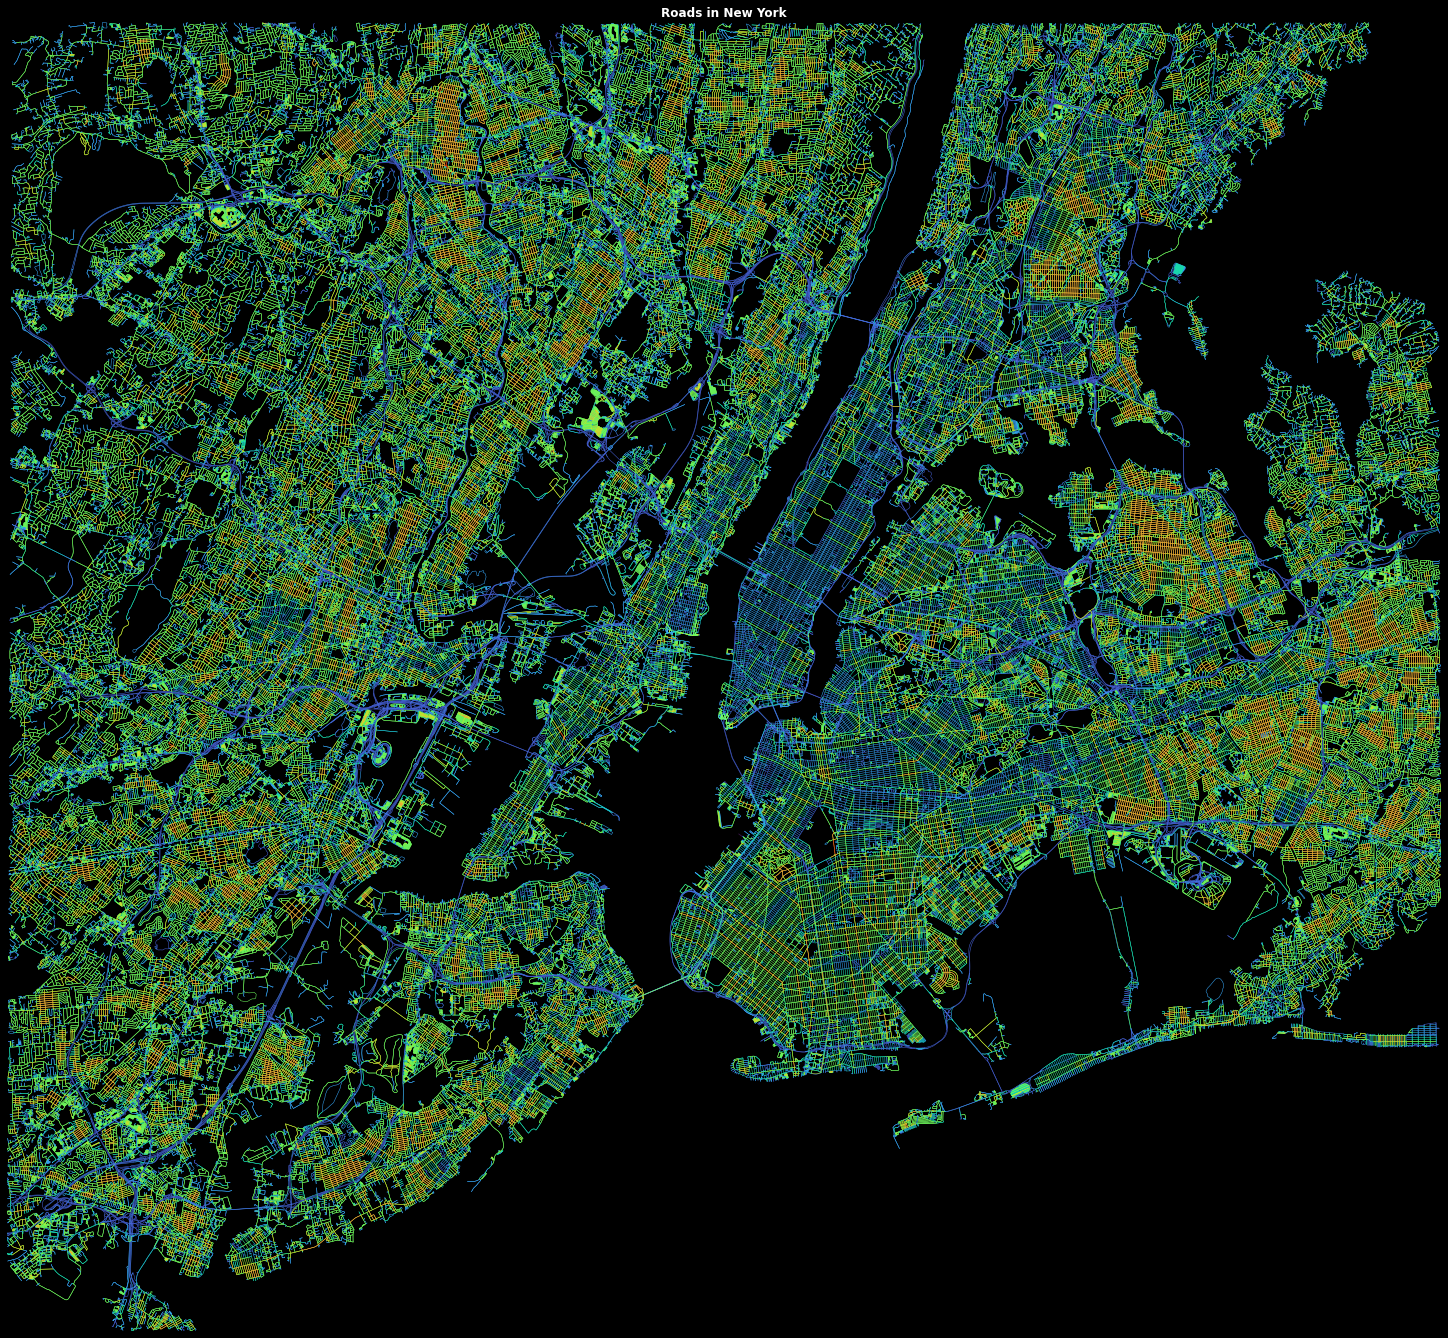

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

joined.plot('centrality', ax=ax, cmap='turbo', alpha=1, lw=0.5)
    
ax.set_title("Roads in New York", color='w', weight='bold')

ax.margins(0)
ax.axis('off')
    
fig.savefig('urban-morphology-nyc-degree-mean.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')